# Time series analysis of hyp3 InSAR products by MintPy

This notebook shows how to do time-series analysis with HyP3 InSAR product by MintPy. We assume you have already got the hyp3 InSAR products somewhere. This steps for the analysis are: clip the hyp3 INSAR product, define the config.txt file, run the time series analysis, and display the results. The sample hyp3 INSAR data are at https://jzhu-hyp3-dev.s3.us-west-2.amazonaws.com/hyp3-mintpy-example/2018_kilauea.zip. Asfar as how to produce the hyp3 INSAR product, we provide the detail steps in the tutorial(https://github.com/ASFHyP3/hyp3-docs/tree/develop/docs). 


## 0. Initial setup of the notebook

To run this notebook, you'll need a conda environment with the required dependencies. You can set up a new environment (recommended) and run the jupyter server like:

conda create -n hyp3-mintpy python=3.8 asf_search hyp3_sdk "mintpy>=1.3.2" pandas jupyter ipympl

To make you conda env accessible in the jupyter notebook, you need to do:

conda activate hyp3-mintpy
conda install -c conda-forge tensorflow
conda install -c anaconda ipykernel
python -m ipykernel install --user --name=hyp3-mintpy

To run your notebook, just:

conda activate hyp3-mintpy
jupyter notebook smallbaselineApp_hyp3_new.ipynb


### Import modules and set environment variables

In [ ]:
import os
from pathlib import Path
import glob
import zipfile
from dateutil.parser import parse as parse_date
from osgeo import gdal
import numpy as np
from mintpy import view, tsview

os.environ['WEATHER_DIR'] = '/media/jzhu4/data/mintpy_data/weather_data'

# utils function

def get_intersect_rectangle_geotiffs(filelist):
    '''
    :param data_dir: data directory storing the hyp3 products.
    :process get the smallest overlap retangular area to clip the geotiff files.
    :return:
    '''
    corners = [gdal.Info(str(dem), format='json')['cornerCoordinates'] for dem in filelist]

    ulx = max(corner['upperLeft'][0] for corner in corners)
    uly = min(corner['upperLeft'][1] for corner in corners)
    lrx = min(corner['lowerRight'][0] for corner in corners)
    lry = max(corner['lowerRight'][1] for corner in corners)
    return [ulx, uly, lrx, lry]

def prepare_hyp3_product(data_dir):
    filelist = glob.glob(f"{data_dir}/*/*_dem.tif")
    insect_box = get_intersect_rectangle_geotiffs(filelist)
    #files_for_mintpy = ['_water_mask.tif', '_corr.tif', '_unw_phase.tif', '_dem.tif', '_lv_theta.tif', '_lv_phi.tif']
    files_for_mintpy = ['_water_mask.tif', '_corr.tif', '_unw_phase.tif', '_dem.tif', '_lv_theta.tif']
    list_product_dirs = [f.path for f in os.scandir(data_dir) if f.is_dir()]

    for product_dir in list_product_dirs:
        for file_suffix in files_for_mintpy:
            product_dir = Path(product_dir)
            src_file = product_dir / f'{product_dir.name}{file_suffix}'
            dst_file = product_dir / f'{src_file.stem}_clipped{src_file.suffix}'
            gdal.Translate(destName=str(dst_file), srcDS=str(src_file), projWin=insect_box)

def unzip_files(zip_file, data_dir):
    if os.path.isfile(zip_file):
        with zipfile.ZipFile(zip_file, 'r') as fzip:
            fzip.extractall(data_dir)


### Define the parameters and create directories

In [ ]:
project_name = 'Ridgecrest'

project_home = '/media/jzhu4/data/hyp3-mintpy'

work_dir = Path(project_home) / project_name

data_dir = work_dir / 'data'

if not os.path.isdir(work_dir):
    os.makedirs(work_dir)
    print('Create directory: {}'.format(work_dir))
    
if not os.path.isdir(data_dir):
    os.makedirs(data_dir)
    print('Create directory: {}'.format(data_dir))
    
os.chdir(work_dir)
print('Go to work directory: {}'.format(work_dir))

## 1. Run MintPy routine workflow `smallbaselineApp.py`

### 1.1 Load the hyp3 InSAR data

The example dataset is from 2018 Kīlauea volcano. The dataset can be obtained through either downloading from the stagged server or producing with hyp3-sdk. Here we provide the sample dataset at https://jzhu-hyp3-dev.s3.us-west-2.amazonaws.com/hyp3-mintpy. 

In [ ]:
file = 'Ridgecrest.zip'

file_url = f'https://jzhu-hyp3-dev.s3.us-west-2.amazonaws.com/hyp3-mintpy-example/{file}'


In [ ]:
!wget {file_url} -P {data_dir}

In [ ]:
print(f'downloaded file is {data_dir}/{file}')

In [ ]:
unzip_files(f'{data_dir}/{file}', data_dir)

### 1.2 Cut geotiff files for mintpy analysis

In [39]:
prepare_hyp3_product(data_dir)

### 1.3 Prepare the template file

In [40]:
mintpy_config = work_dir / 'mintpy_config.txt'
mintpy_config.write_text(
f"""
mintpy.load.processor        = hyp3
##---------interferogram datasets:
mintpy.load.unwFile          = {data_dir}/*/*_unw_phase_clipped.tif
mintpy.load.corFile          = {data_dir}/*/*_corr_clipped.tif
##---------geometry datasets:
mintpy.load.demFile          = {data_dir}/*/*_dem_clipped.tif
mintpy.load.incAngleFile     = {data_dir}/*/*_lv_theta_clipped.tif
#mintpy.load.azAngleFile      = {data_dir}/*/*_lv_phi_clipped.tif
mintpy.load.waterMaskFile    = {data_dir}/*/*_water_mask_clipped.tif
""")

707

### 1.4 Run Time-series Analysis application

In [41]:
! smallbaselineApp.py --work-dir {work_dir}  {mintpy_config}


___________________________________________________________

  /##      /## /##             /##     /#######           
 | ###    /###|__/            | ##    | ##__  ##          
 | ####  /#### /## /#######  /######  | ##  \ ## /##   /##
 | ## ##/## ##| ##| ##__  ##|_  ##_/  | #######/| ##  | ##
 | ##  ###| ##| ##| ##  \ ##  | ##    | ##____/ | ##  | ##
 | ##\  # | ##| ##| ##  | ##  | ## /##| ##      | ##  | ##
 | ## \/  | ##| ##| ##  | ##  |  ####/| ##      |  #######
 |__/     |__/|__/|__/  |__/   \___/  |__/       \____  ##
                                                 /##  | ##
                                                |  ######/
   Miami InSAR Time-series software in Python    \______/ 
          MintPy v1.3.3, 2022-04-14
___________________________________________________________

--RUN-at-2022-05-05 20:15:43.276408--
Current directory: /media/jzhu4/data/hyp3-mintpy/Ridgecrest
Run routine processing with smallbaselineApp.py on steps: ['load_data', 'modify_network', 'ref

read options from template file: smallbaselineApp.cfg
read temporal/spatial baseline info from file: /media/jzhu4/data/hyp3-mintpy/Ridgecrest/inputs/ifgramStack.h5
open ifgramStack file: ifgramStack.h5
calculating spatial mean of coherence in file /media/jzhu4/data/hyp3-mintpy/Ridgecrest/inputs/ifgramStack.h5 ...
read mask from file: waterMask.h5
[==================================================] 11/11    0s /     0s 
write average value in space into text file: coherenceSpatialAvg.txt
number of acquisitions: 7
number of interferograms: 11
shift all perp baseline by 88.67054748535156 to zero mean for plotting
--------------------------------------------------
number of interferograms marked as drop: 0
number of interferograms marked as keep: 11
number of acquisitions marked as drop: 0
save figure to pbaseHistory.pdf
save figure to coherenceMatrix.pdf
save figure to coherenceHistory.pdf
max perpendicular baseline: 111.93 m
max temporal      baseline: 24.0 days
showing coherence
data r

calculating weight from spatial coherence ...
reading coherence in (0, 0, 3633, 2859) * 11 ...
convert coherence to weight in chunks of 100000 pixels: 104 chunks in total ...
convert coherence to weight using inverse of phase variance
    with phase PDF for distributed scatterers from Tough et al. (1995)
    number of independent looks L=41
chunk 1 / 104
chunk 2 / 104
chunk 3 / 104
chunk 4 / 104
chunk 5 / 104
chunk 6 / 104
chunk 7 / 104
chunk 8 / 104
chunk 9 / 104
chunk 10 / 104
chunk 11 / 104
chunk 12 / 104
chunk 13 / 104
chunk 14 / 104
chunk 15 / 104
chunk 16 / 104
chunk 17 / 104
chunk 18 / 104
chunk 19 / 104
chunk 20 / 104
chunk 21 / 104
chunk 22 / 104
chunk 23 / 104
chunk 24 / 104
chunk 25 / 104
chunk 26 / 104
chunk 27 / 104
chunk 28 / 104
chunk 29 / 104
chunk 30 / 104
chunk 31 / 104
chunk 32 / 104
chunk 33 / 104
chunk 34 / 104
chunk 35 / 104
chunk 36 / 104
chunk 37 / 104
chunk 38 / 104
chunk 39 / 104
chunk 40 / 104
chunk 41 / 104
chunk 42 / 104
chunk 43 / 104
chunk 44 / 104
chunk 

* referencing data from ERA5.h5 to y/x: 1681/1987
* referencing data from ERA5.h5 to date: 20190610
read from file: /media/jzhu4/data/hyp3-mintpy/Ridgecrest/timeseries.h5
--------------------------------------------------
open  HDF5 file /media/jzhu4/data/hyp3-mintpy/Ridgecrest/timeseries_ERA5.h5 in a mode
writing dataset /timeseries                block: [0, 7, 0, 2859, 0, 3633]
close HDF5 file /media/jzhu4/data/hyp3-mintpy/Ridgecrest/timeseries_ERA5.h5.
time used: 00 mins 1.9 secs


******************** step - deramp ********************
No phase ramp removal.


******************** step - correct_topography ********************
Input data seems to be geocoded. Lookup file not needed.

dem_error.py /media/jzhu4/data/hyp3-mintpy/Ridgecrest/timeseries_ERA5.h5 -t /media/jzhu4/data/hyp3-mintpy/Ridgecrest/smallbaselineApp.cfg -o /media/jzhu4/data/hyp3-mintpy/Ridgecrest/timeseries_ERA5_demErr.h5 --update -g /media/jzhu4/data/hyp3-mintpy/Ridgecrest/inputs/geometryGeo.h5
read options from te

--------------------------------------------------
change reference date for file: /media/jzhu4/data/hyp3-mintpy/Ridgecrest/timeseries_ERA5.h5
reading data ...
referencing in time ...
--------------------------------------------------
open  HDF5 file /media/jzhu4/data/hyp3-mintpy/Ridgecrest/timeseries_ERA5.h5 in r+ mode
writing dataset /timeseries                block: (0, 7, 0, 2859, 0, 3633)
close HDF5 file /media/jzhu4/data/hyp3-mintpy/Ridgecrest/timeseries_ERA5.h5.
update "REF_DATE" attribute value to 20190821
--------------------------------------------------
change reference date for file: /media/jzhu4/data/hyp3-mintpy/Ridgecrest/timeseries_ERA5_demErr.h5
reading data ...
referencing in time ...
--------------------------------------------------
open  HDF5 file /media/jzhu4/data/hyp3-mintpy/Ridgecrest/timeseries_ERA5_demErr.h5 in r+ mode
writing dataset /timeseries                block: (0, 7, 0, 2859, 0, 3633)
close HDF5 file /media/jzhu4/data/hyp3-mintpy/Ridgecrest/timeseries_E

view.py --dpi 150 --noverbose --nodisplay --update --memory 4.0 inputs/ifgramStack.h5 unwrapPhase- --zero-mask
view.py --dpi 150 --noverbose --nodisplay --update --memory 4.0 inputs/ifgramStack.h5 coherence- --mask no -v 0 1
view.py --dpi 150 --noverbose --nodisplay --update --memory 4.0 avgPhaseVelocity.h5
view.py --dpi 150 --noverbose --nodisplay --update --memory 4.0 avgSpatialCoh.h5 -c gray -v 0 1
view.py --dpi 150 --noverbose --nodisplay --update --memory 4.0 maskConnComp.h5 -c gray -v 0 1
view.py --dpi 150 --noverbose --nodisplay --update --memory 4.0 timeseries.h5 --noaxis -u cm --wrap --wrap-range -5 5
view.py --dpi 150 --noverbose --nodisplay --update --memory 4.0 timeseries_ERA5.h5 --noaxis -u cm --wrap --wrap-range -5 5
view.py --dpi 150 --noverbose --nodisplay --update --memory 4.0 timeseries_ERA5_demErr.h5 --noaxis -u cm --wrap --wrap-range -5 5
view.py --dpi 150 --noverbose --nodisplay --update --memory 4.0 velocityERA5.h5 --mask no
view.py --dpi 150 --noverbose --nodispl

## 2. Display the analysis results

There are a few scripts used to display the analysis results. There are in the MINTPY_HOME/mintpy. Here we show two majoy disaply scripts.

In [42]:
%matplotlib widget
from mintpy import view, tsview

run view.py in MintPy version v1.3.3, date 2022-04-14
input file is velocity file: /media/jzhu4/data/hyp3-mintpy/Ridgecrest/velocity.h5 in float32 format
file size in y/x: (2859, 3633)
num of datasets in file velocity.h5: 2
datasets to exclude (0):
[]
datasets to display (2):
['velocity', 'velocityStd']
data   coverage in y/x: (0, 0, 3633, 2859)
subset coverage in y/x: (0, 0, 3633, 2859)
data   coverage in lat/lon: (312640.0, 4042400.0, 603280.0, 3813680.0)
subset coverage in lat/lon: (312640.0, 4042400.0, 603280.0, 3813680.0)
------------------------------------------------------------------------
colormap: jet
figure title: velocity
figure size : [15.00, 8.00]
dataset number: 2
row     number: 1
column  number: 2
figure  number: 1
read mask from file: maskTempCoh.h5
----------------------------------------
Figure 1 - velocity.png
reading data as a list of 2D matrices ...
[==================================================] velocityStd 0s /     0s 
data    range: [-745.02423, 731.7804

/home/jzhu4/apps/anaconda3/envs/hyp3-mintpy/lib/python3.8/site-packages/mintpy/view.py:1355: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


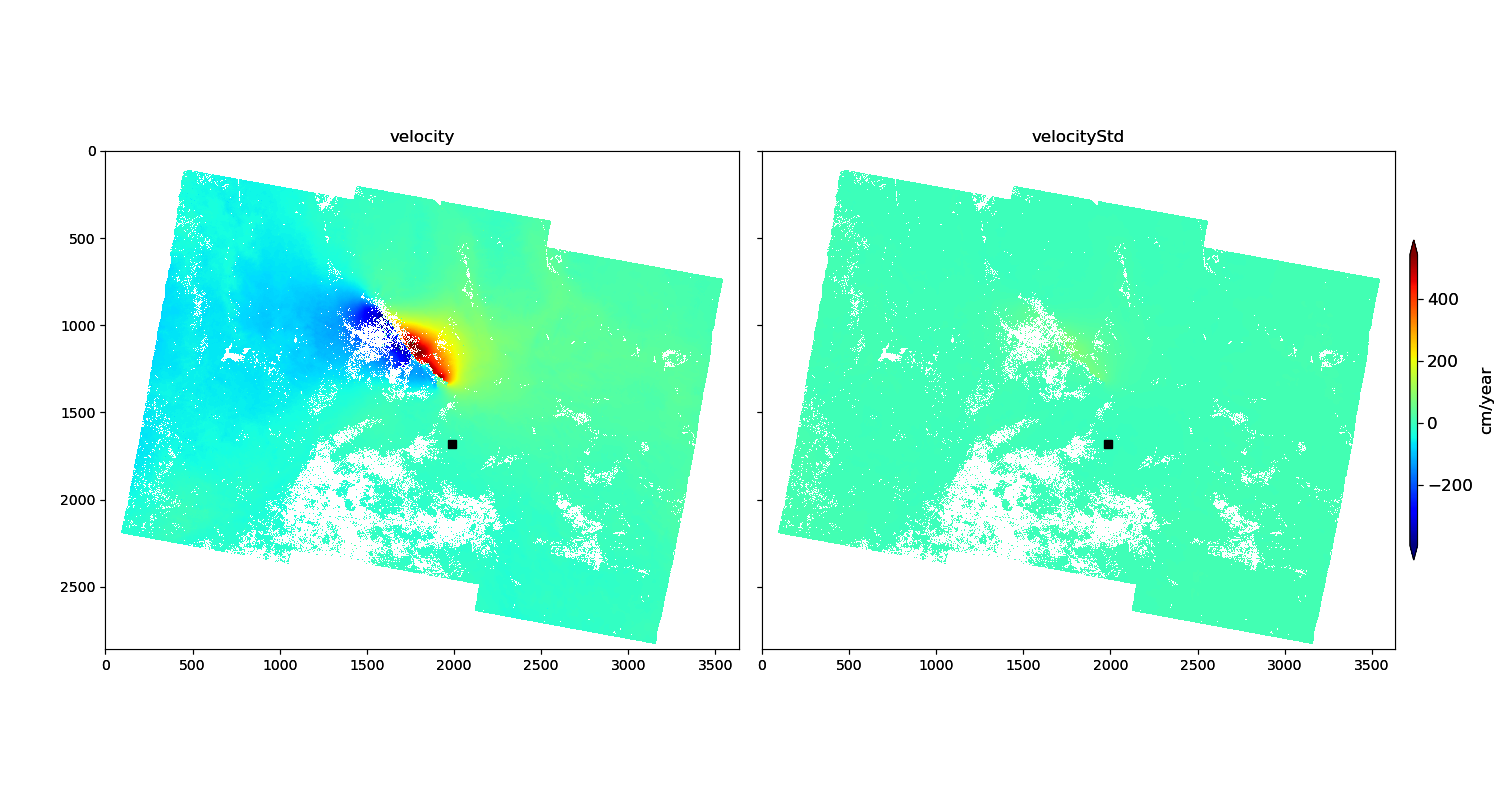

In [44]:
view.main([f'{work_dir}/velocity.h5'])

tsview.py /media/jzhu4/data/hyp3-mintpy/Ridgecrest/timeseries.h5
open timeseries file: timeseries.h5
exclude date:['20190704', '20190716']
No lookup table info range/lat found in files.
data   coverage in y/x: (0, 0, 3633, 2859)
subset coverage in y/x: (0, 0, 3633, 2859)
data   coverage in lat/lon: (312640.0, 4042400.0, 603280.0, 3813680.0)
subset coverage in lat/lon: (312640.0, 4042400.0, 603280.0, 3813680.0)
------------------------------------------------------------------------
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    step       : []
    exp        : {}
    log        : {}
reading timeseries from file /media/jzhu4/data/hyp3-mintpy/Ridgecrest/timeseries.h5
reference to date: 20190821
read mask from file: maskTempCoh.h5
data    range: [-78.073875, 93.78707] cm
display range: [-69.005554, 51.61355] cm
figure size : [8.29, 6.00]
display data in transparency: 1.0
plot in geo-coordinate
plotting image ...
plot scale 

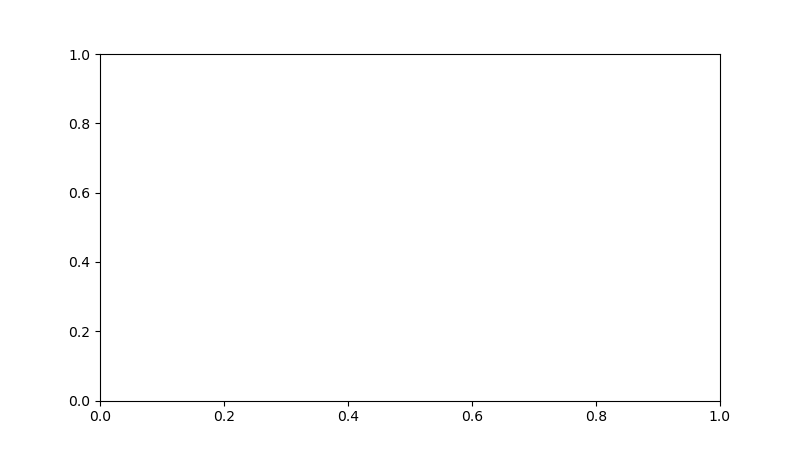

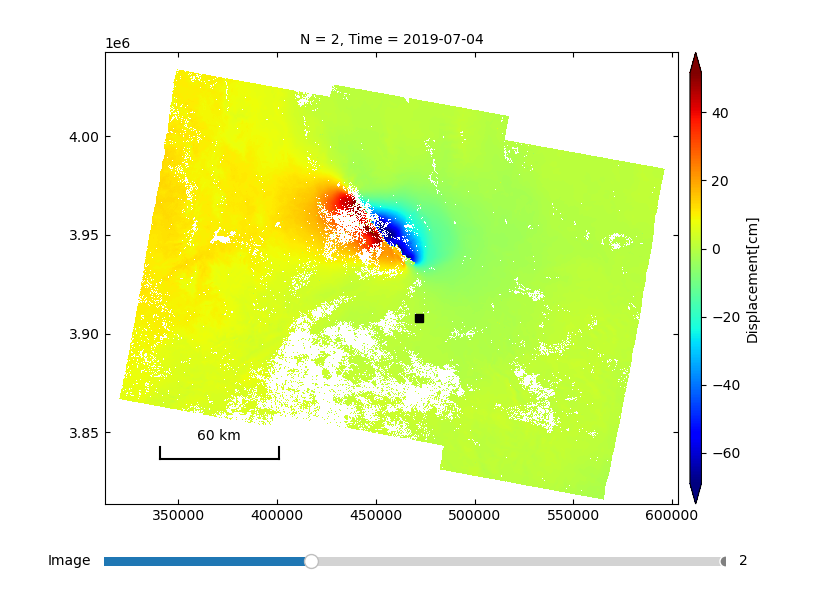

In [45]:
tsview.main([f'{work_dir}/timeseries.h5'])